In [6]:
import numpy as np
import os

from scipy.spatial import distance
import pandas as pd
import matplotlib.pyplot as plt    
import networkx as nx
import copy
from scipy import stats
from copy import deepcopy
import time
import seaborn as sns

from scipy.optimize import curve_fit

import louvain
import leidenalg
import igraph as ig

In [2]:
A_undirected = np.load("undirected_adj_synaptic_cleft_5.000 um.npy")
A_directed = np.load("adjacency_synaptic_cleft_5.000um.npy")

neuron_names = pd.read_csv("neuron_names.txt", header=None).iloc[:,0].tolist()

In [3]:
def plot_constbin(degree):
    degree = np.array(degree) # if list convert to np array
    deg = degree[degree>0] # don't consider values=0

    edges= np.histogram_bin_edges(deg,bins='auto')
    pk = np.array(plt.hist(deg,bins=edges,density=True))[0]

    plt.close()

    edges2 = list(edges[1:])+[0]

    mid_point = (np.array([a+b for a,b in zip(edges,edges2)])/2)[:-1]
    #print("Constant automated binning:")
    #print("first 5 bin edges:",edges[:5])
    #print("first 5 pk(as density instead of counts), y values:",pk[:5])
    #print("first 5 mid-point of bin edges, x values:",mid_point[:5])
    #print("min(K_out): ",min(out_deg))
    plt.figure(figsize=(6,4))
    
    plt.loglog(mid_point, pk,'.',color="orangered")
    
    plt.xlabel("x",size=15)
    plt.ylabel("$P(x)$",size=15)
    #plt.title("log-log plot with automated \n optimized x-axis binning, bin size = %.2f"%(edges[1]-edges[0]),
    #          size=14)
    print("bin size: ",(edges[1]-edges[0]))
    
    plt.tick_params(direction='in',bottom=True,top=True,left=True,right=True)
    plt.grid(linestyle='--',alpha=0.5,which='both')
    

    #plt.savefig("./neurites_axonTermials/simple_bin_kout.png")
    plt.show()      


In [4]:
def get_graph_undirected(adjacency, neuron_namesfile):
    G = nx.from_numpy_matrix(adjacency)#, create_using=nx.MultiGraph)
    f = open(neuron_namesfile,"r") #opens file with name of "test.txt"
    neuron_names = []
    for line in f:
        neuron_names.append(line[:-1]) #[:-1] because we don't want /n in the end.  
        
    nx.set_node_attributes(G, dict(zip(list(G.nodes()),neuron_names)) , "name")    
    return G


In [5]:
def get_graph_directed(adj_matfile, neuron_namesfile):
    # import the adjacency matrix from text file
    adjacency = np.load(adj_matfile)
    #print("Shape of adjacency matrix:", adjacency.shape)

    # import names of each neuron
    f = open(neuron_namesfile,"r") #opens file with name of "test.txt"
    neuron_names = []
    for line in f:
        neuron_names.append(line[:-1]) #[:-1] because we don't want /n in the end.  
    #print((neuron_names2))
    n_neurons = len(neuron_names)
    #print("Total number of neurons:",n_neurons)
    
    # create node and node attributes which is the name for the graph
    nodes_list = []
    for i in range(len(neuron_names)):
        #node attribute is given by its neuron name
        nodes_list.append((i,{"name":neuron_names[i]}))
    #print(len(nodes_list))

    # creating an edge list from adjacency matrix
    edge_list=[]
    for i in range(len(neuron_names)):
        for j in range(len(neuron_names)):
            if adjacency[i,j]==0: # if there's no weight, let's forget the edge.
                pass
            else:
                edge_list.append( (i,j,{"weight":adjacency[i,j],"Label":"%s - %s"%(neuron_names[i],neuron_names[j])}) )
    # Creating a directed graph from adjacency matrix so that it will be easy to deal using the networkx module

    G = nx.DiGraph()

    # Add all the nodes to the graph
    G.add_nodes_from(nodes_list)
    # Add all the edges to the graph
    G.add_edges_from(edge_list)
    
    #GC =  G.subgraph(max(nx.strongly_connected_components(G), key=len))

    return G#adjacency, neuron_names, n_neurons, G


In [ ]:
# Plt community matrix

from matplotlib import patches
# http://sociograph.blogspot.com/2012/11/visualizing-adjacency-matrices-in-python.html

def draw_adjacency_matrix(G, node_order=None, partitions=[], colors=[]):
    """
    - G is a networkx graph
    - node_order (optional) is a list of nodes, where each node in G
          appears exactly once
    - partitions is a list of node lists, where each node in G appears
          in exactly one node list
    - colors is a list of strings indicating what color each
          partition should be
    If partitions is specified, the same number of colors needs to be
    specified.
    """
    adjacency_matrix = nx.to_numpy_matrix(G, dtype=bool, nodelist=node_order)

    #Plot adjacency matrix in toned-down black and white
    fig = plt.figure(figsize=(5, 5)) # in inches
    plt.imshow(adjacency_matrix,
                  cmap="Greys",
                  interpolation="none")
    
    # The rest is just if you have sorted nodes by a partition and want to
    # highlight the module boundaries
    #print(partitions)
    assert len(partitions) == len(colors)
    ax = plt.gca()
    for partition, color in zip(partitions, colors):
        current_idx = 0
        for module in partition:
            ax.add_patch(patches.Rectangle((current_idx, current_idx),
                                          len(module), # Width
                                          len(module), # Height
                                          facecolor="none",
                                          edgecolor=color,
                                          linewidth="1"))
            current_idx += len(module)
            
            
def findMiddle(input_list):
    middle = float(len(input_list))/2
    if middle % 2 != 0:
        return input_list[int(middle - .5)]
    else:
        return int((input_list[int(middle)] + input_list[int(middle-1)])/2)
    
from collections import defaultdict

def plot_community_matrix(G_nx, G_ig, louvain_community_dict):

    louvain_comms = defaultdict(list)
    for node_index, comm_id in louvain_community_dict.items():
        louvain_comms[comm_id].append(node_index)
        
    ordered_comm_keys = list(louvain_comms.keys())
    # order_comm_list_values is simply all the members of a community
    mid_point_ticks = [findMiddle(list(order_comm_list_values)) for order_comm_list_values in louvain_comms.values() ]
    
    # partition 0 to N based on community size
    partitioned_list_02N = []
    count=0
    for value in louvain_comms.values():
        sublist = []
        for i in range(len(value)):
            sublist.append(count)
            count+=1
        partitioned_list_02N.append(sublist)
    
    mid_point_ticks = [np.mean(sublist) for sublist in partitioned_list_02N ]
    
    louvain_comms = louvain_comms.values()


    nodes_louvain_ordered = [node for comm in louvain_comms for node in comm]
    draw_adjacency_matrix(G_nx, nodes_louvain_ordered, [louvain_comms], ["blue"])
    
    xticks_comm_name = ordered_comm_keys 
    plt.xticks(mid_point_ticks, xticks_comm_name)
    plt.yticks(mid_point_ticks, xticks_comm_name)

    plt.title("No. of comms: %d"%(len(louvain_comms)))


# Undirected network analysis

In [7]:
G_undir_nx = get_graph_undirected(A_undirected, "neuron_names.txt")

components = nx.connected_components(G_undir_nx)
lcclist = sorted(list(components), key = len, reverse=True)

GC_undir_nx = nx.subgraph(G_undir_nx, lcclist[0])
# convert nx graph to igraph
#GC_undir_ig = ig.Graph.from_networkx(GC_undir_nx)


In [8]:
G_undir_nx.number_of_nodes()


3163

In [6]:
for i in range(len(lcclist)):
    print(i, len(lcclist[i]))

0 3131
1 7
2 3
3 2
4 2
5 2
6 1
7 1
8 1
9 1
10 1
11 1
12 1
13 1
14 1
15 1
16 1
17 1
18 1
19 1
20 1
21 1


In [8]:
nnodes_lcc = [len(lis) for lis in lcclist  ]

/home/karan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


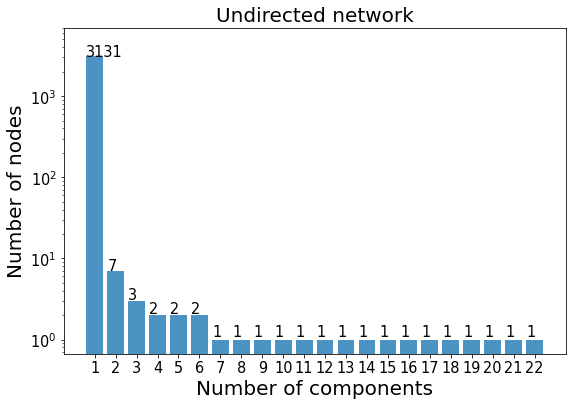

In [30]:
plt.figure(figsize=(9,6))
plt.rcParams['font.size']=14.5

bars = plt.bar(range(1,len(nnodes_lcc)+1), nnodes_lcc, alpha=0.8)


# access the bar attributes to place the text in the appropriate location
for bar,nnodes in zip(bars, nnodes_lcc):
    yval = bar.get_height()
    plt.text(bar.get_x(), yval + .1, nnodes)


plt.yscale("log")
plt.xticks(range(1,len(nnodes_lcc)+1), range(1,len(nnodes_lcc)+1))

plt.xlabel("Number of components",size=20 )
plt.ylabel("Number of nodes",size=20)
plt.title("Undirected network", size=20)
plt.ylim([0,7000])
plt.savefig("components_undir.pdf", facecolor="white", bbox_inches="tight", dpi=600)


plt.show()

In [10]:
G_undir_nx.number_of_edges()

194825

In [11]:
GC_undir_nx.number_of_edges()

194811

In [12]:
nx.density(GC_undir_nx)

0.03975722523298398

In [16]:
nx.average_clustering(GC_undir_nx)

0.41930479453512365

In [15]:
nx.average_clustering(GC_undir_nx, weight="weight")

0.0020334183253785977

In [18]:
nx.average_shortest_path_length(GC_undir_nx)

2.4178942309360276

In [19]:
nx.average_shortest_path_length(GC_undir_nx, weight="weight")

3.792019412185473

bin size:  339.36467236467234


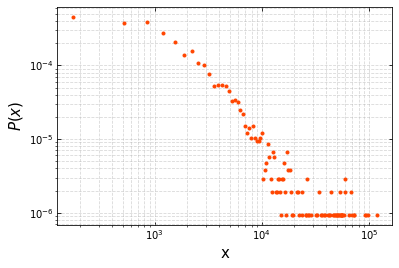

In [13]:
#in_deg =  list(dict(G.in_degree(G.nodes, weight='weight')).values())
#out_deg = list(dict(G.out_degree(G.nodes, weight='weight')).values())
deg = list(dict(GC_undir_nx.degree(GC_undir_nx.nodes, weight='weight')).values())
plot_constbin(deg)

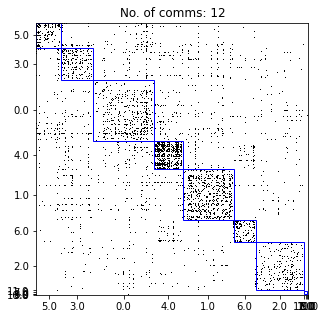

In [20]:
df = pd.read_csv("averaged_undir_leiden.csv")
undir_comm_dict =  dict(zip(df.Node, df.Community))

plot_community_matrix(GC_undir_nx, GC_undir_ig, undir_comm_dict)

# Directed network analysis

In [13]:
fname = "adjacency_synaptic_cleft_5.000um.npy"

#fname = "./neurites_axonTermials/adjacency_axon25July.txt"#+str(10)+".txt"

G_dir_nx = get_graph_directed(fname, "neuron_names.txt")
GC_dir_nx =  G_dir_nx.subgraph(max(nx.weakly_connected_components(G_dir_nx), key=len))



In [24]:
in_deg = np.array(list(dict(GC_dir_nx.in_degree(GC_dir_nx.nodes, weight='weight')).values()))
out_deg = np.array(list(dict(GC_dir_nx.out_degree(GC_dir_nx.nodes, weight='weight')).values()))


In [35]:
def plot_constbin2(degree):
    degree = np.array(degree) # if list convert to np array
    deg = degree[degree>0] # don't consider values=0
    binsize=75
    nbins = int((max(deg)-min(deg))/binsize)
    edges= np.histogram_bin_edges(deg,bins=nbins)# bins="auto"
    pk = np.array(plt.hist(deg,bins=edges,density=True))[0]

    plt.close()

    edges2 = list(edges[1:])+[0]

    mid_point = (np.array([a+b for a,b in zip(edges,edges2)])/2)[:-1]
    #plt.loglog(mid_point, pk,'.',color=color)
    return mid_point, pk
    
    #print(min(mid_point), max(mid_point))
    #print(min(pk), max(pk))
    
    #print("bin size: ",(edges[1]-edges[0]))
    

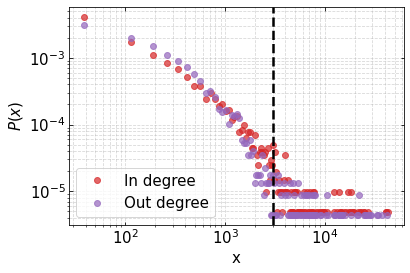

In [71]:

mid_point1, pk1 = plot_constbin2(in_deg)

mid_point2, pk2 = plot_constbin2(out_deg)


plt.loglog(mid_point1, pk1,'o', alpha=0.7, color='#d62728', label='In degree')

plt.loglog(mid_point2, pk2,'o', alpha=0.7,color='#9467bd', label='Out degree')
plt.axvline(3000,ls="--", linewidth=2.5,color="k" )

plt.tick_params(direction='in',bottom=True,top=True,left=True,right=True)
plt.grid(linestyle='--',alpha=0.5,which='both')
plt.xlabel("x",size=15)
plt.ylabel("$P(x)$",size=15)
plt.legend(loc='best')#, prop={'size':15})

plt.rcParams['font.size']=15
plt.savefig("In_out_degree_distribution.pdf",  facecolor="white", bbox_inches="tight", dpi=600)

#plt.xlim([37,44000])
#plt.ylim([0,0.0045])
# binsize=75
    
        

# properties of directed network

In [5]:
components = list(nx.weakly_connected_components(G_dir_nx))
lcclist = sorted(list(components), key = len, reverse=True)


/home/karan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


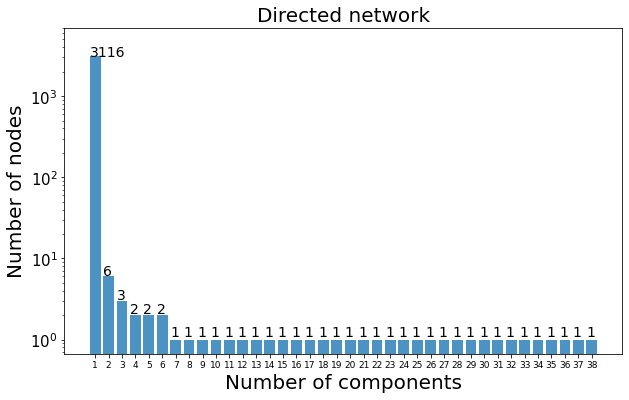

In [14]:
nnodes_lcc = [len(lis) for lis in lcclist  ]
plt.figure(figsize=(10,6))
#plt.rcParams['font.size']=12

bars = plt.bar(np.array(list(range(1,len(nnodes_lcc)+1)))*1, nnodes_lcc, alpha=0.8, linewidth=3)


# access the bar attributes to place the text in the appropriate location
for bar,nnodes in zip(bars, nnodes_lcc):
    yval = bar.get_height()
    plt.text(bar.get_x(), yval + .1, nnodes, size=14)


plt.yscale("log")
plt.xticks(range(1,len(nnodes_lcc)+1), range(1,len(nnodes_lcc)+1), fontsize=9)
plt.yticks(fontsize=15)

plt.xlabel("Number of components",size=20 )
plt.ylabel("Number of nodes",size=20)
plt.title("Directed network", size=20)
plt.ylim([0,7000])
plt.savefig("components_dir.pdf", facecolor="white", bbox_inches="tight", dpi=600)


plt.show()

In [14]:
G_dir_nx.number_of_edges()

100934

In [15]:
nx.density(GC_dir_nx)

0.010397430957497882

In [20]:
nx.average_clustering(GC_dir_nx)

0.0757932108862268

In [21]:
nx.average_clustering(GC_dir_nx, weight="weight")

0.0005030268599138647

In [22]:
nx.average_shortest_path_length(GC_dir_nx)

2.632528120795274

In [23]:
nx.average_shortest_path_length(GC_dir_nx, weight="weight")

6.107510348905973

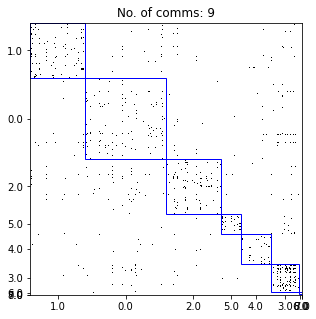

In [23]:
df = pd.read_csv("averaged_dir_leiden.csv")
dir_comm_dict =  dict(zip(df.Node, df.Community))

plot_community_matrix(GC_dir_nx, GC_dir_ig, dir_comm_dict)

bin size:  89.81818181818181


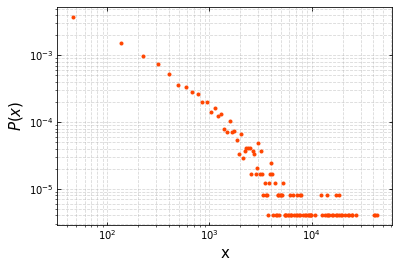

bin size:  65.16820987654322


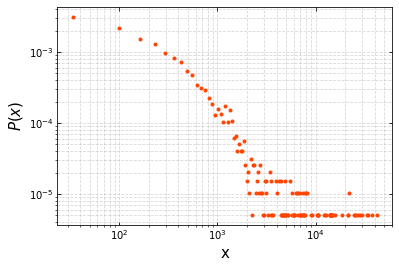

In [22]:
# Automated binning distribution plot

in_deg = list(dict(GC_dir_nx.in_degree(GC_dir_nx.nodes, weight='weight')).values())
out_deg = list(dict(GC_dir_nx.out_degree(GC_dir_nx.nodes, weight='weight')).values())

plot_constbin(in_deg)

plot_constbin(out_deg)

# Specificity score

In [70]:
df_dir = pd.read_csv("averaged_dir_leiden.csv")
cmt_num_dir = sorted(df_dir.Community.unique().tolist())[:7]

df_undir = pd.read_csv("averaged_undir_leiden.csv")
cmt_num_undir = sorted(df_undir.Community.unique().tolist())[:8]

ncomm_undir = len(cmt_num_undir)
ncomm_dir = len(cmt_num_dir)

In [75]:

spec_array = []
for i in cmt_num_dir:
    
    df_i = df_dir.groupby("Community").get_group(i)

    nodes_Cmt1 = df_i.Node.tolist()
    
    for j in cmt_num_undir:
        
        df_j = df_undir.groupby("Community").get_group(j)

        nodes_Cmt2 = df_j.Node.tolist()
            
        common_nodes = set(nodes_Cmt1).intersection(set(nodes_Cmt2))
        
        spec_score = len(common_nodes)/len(nodes_Cmt1)
        spec_array.append(spec_score)

spec_array = np.array(spec_array).reshape((ncomm_dir, ncomm_undir))
spec_array = spec_array[:,[0,3,1,4,2,5,6,7]]

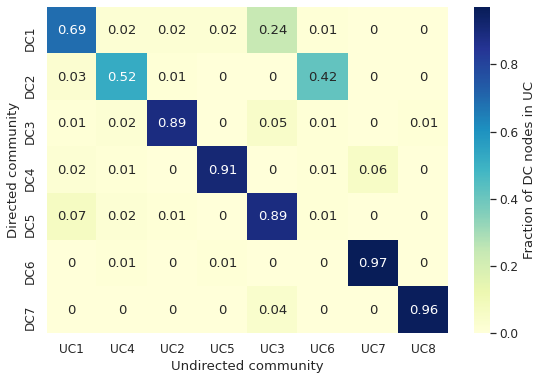

In [76]:

plt.figure(figsize=(9,6))
sns.set(font_scale=1.1)

sns.heatmap(np.round(spec_array,2), cmap="YlGnBu", annot=True,
            xticklabels=["UC%d"%(i+1) for i in [0,3,1,4,2,5,6,7]],
           yticklabels=["DC%d"%(i+1) for i in range(ncomm_dir) ], 
           cbar_kws={'label': 'Fraction of DC nodes in UC'})

# update the desired text annotations
#for text in ax.texts:
#    if text.get_text() == '0.00':
#        text.set_text('0')

plt.xlabel("Undirected community")
plt.ylabel("Directed community")
#plt.title("Community specificity score(Leiden)")



plt.savefig("percent_dir_to_undir.pdf",  facecolor="white", bbox_inches="tight", dpi=600 )

# Comparison UC DC, common nodes

In [89]:
df_dir = pd.read_csv("averaged_dir_leiden.csv")
cmt_num_dir = sorted(df_dir.Community.unique().tolist())[:7]

df_undir = pd.read_csv("averaged_undir_leiden.csv")
cmt_num_undir = sorted(df_undir.Community.unique().tolist())[:8]

ncomm_undir = len(cmt_num_undir)
ncomm_dir = len(cmt_num_dir)


spec_array = []
for i in cmt_num_dir:
    
    df_i = df_dir.groupby("Community").get_group(i)

    nodes_Cmt1 = df_i.Node.tolist()
    
    for j in cmt_num_undir:
        
        df_j = df_undir.groupby("Community").get_group(j)

        nodes_Cmt2 = df_j.Node.tolist()
            
        common_nodes = set(nodes_Cmt1).intersection(set(nodes_Cmt2))
        
        spec_score = len(common_nodes)#/len(nodes_Cmt1)
        spec_array.append(spec_score)

spec_array = np.array(spec_array).reshape((ncomm_dir, ncomm_undir))
#spec_array = spec_array[:,[0,3,1,4,2,5,6,7]]

In [90]:
spec_array

array([[639,  21, 219,  15,  23,   6,   0,   4],
       [ 19,   9,   2, 330,   2, 263,   1,   0],
       [  9, 556,  30,  10,   2,   8,   2,   7],
       [  8,   0,   1,   2, 296,   2,  18,   0],
       [ 23,   4, 303,   7,   0,   2,   0,   0],
       [  0,   1,   0,   2,   3,   0, 228,   0],
       [  0,   0,   1,   0,   0,   0,   0,  26]])

In [91]:
np.savetxt("undir_dir_commMatrix.txt", spec_array, fmt="%d")

# Finding Hubs

In [22]:
# undirected network

d = dict(GC_undir_nx.degree(weight="weight"))
d = dict((k, v) for k, v in d.items() if v >= 10000)
hubs = list(d.keys())

print(len(hubs))

node_name_dict = nx.get_node_attributes(GC_undir_nx, "name")
hub_names=[]
for node in hubs:
    hub_names.append(node_name_dict[node])
print(len(hub_names) )   

158
158


In [23]:

textfile = open("undir_hub_names_10e4.txt", "w")

for element in hub_names:

    textfile.write(element + "\n")

textfile.close()

In [72]:
# directed network _ IN degree

d = dict(GC_dir_nx.in_degree(weight="weight"))


d = dict((k, v) for k, v in d.items() if v >= 3000)
hubs = list(d.keys())

print(len(hubs))

node_name_dict = nx.get_node_attributes(GC_dir_nx, "name")
hub_names=[]
for node in hubs:
    hub_names.append(node_name_dict[node])
print(len(hub_names) )   



textfile = open("dir_hubIn_names_3e3.txt", "w")

for element in hub_names:

    textfile.write(element + "\n")

textfile.close()

133
133


In [73]:
# directed network _ OUT degree

d = dict(GC_dir_nx.out_degree(weight="weight"))


d = dict((k, v) for k, v in d.items() if v >= 3000)
hubs = list(d.keys())

print(len(hubs))

node_name_dict = nx.get_node_attributes(GC_dir_nx, "name")
hub_names=[]
for node in hubs:
    hub_names.append(node_name_dict[node])
print(len(hub_names) )   



textfile = open("dir_hubOut_names_3e3.txt", "w")

for element in hub_names:

    textfile.write(element + "\n")

textfile.close()

113
113


# Leiden Community Connectivity matrix

## Directed case

In [93]:
df_dir = pd.read_csv("averaged_dir_leiden.csv")
cmt_num_dir = sorted(df_dir.Community.unique().tolist())[:7]

df_undir = pd.read_csv("averaged_undir_leiden.csv")
cmt_num_undir = sorted(df_undir.Community.unique().tolist())[:8]

ncomm_undir = len(cmt_num_undir)
ncomm_dir = len(cmt_num_dir)

In [95]:
fname = "adjacency_synaptic_cleft_5.000um.npy"
G_dir_nx = get_graph_directed(fname, "neuron_names.txt")
GC_dir_nx =  G_dir_nx.subgraph(max(nx.weakly_connected_components(G_dir_nx), key=len))


In [96]:
%%time

comm_connnectivity_array = []

for i in cmt_num_dir:
    
    df_i = df_dir.groupby("Community").get_group(i)

    nodes_Cmt1 = df_i.Node.tolist()
    
    for j in cmt_num_dir:
        
        df_j = df_dir.groupby("Community").get_group(j)
        
        nodes_Cmt2 = df_j.Node.tolist()
        
        count=0
        for i in nodes_Cmt1:
            for j in nodes_Cmt2:
                if GC_dir_nx.has_edge(i, j):
                    count+=1
        comm_connnectivity_array.append(count)            
        

comm_connnectivity_array = np.array(comm_connnectivity_array).reshape((ncomm_dir, ncomm_dir))        
    



CPU times: user 16.6 s, sys: 0 ns, total: 16.6 s
Wall time: 16.6 s


In [97]:
np.diag(np.diag(comm_connnectivity_array))

array([[18356,     0,     0,     0,     0,     0,     0],
       [    0, 10995,     0,     0,     0,     0,     0],
       [    0,     0, 15419,     0,     0,     0,     0],
       [    0,     0,     0, 13518,     0,     0,     0],
       [    0,     0,     0,     0,  3718,     0,     0],
       [    0,     0,     0,     0,     0,  4995,     0],
       [    0,     0,     0,     0,     0,     0,   119]])

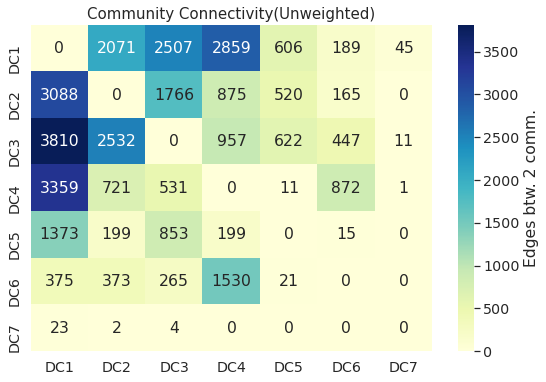

In [101]:
plt.figure(figsize=(9,6))

#sns.heatmap(comm_connectivity_array  , cmap="YlGnBu")
connect_arr = deepcopy(comm_connnectivity_array)
connect_arr = connect_arr-np.diag(np.diag(comm_connnectivity_array))

sns.set(font_scale=1.3)

sns.heatmap(connect_arr, annot=True, fmt="d",cmap="YlGnBu",
            cbar_kws={'label': 'Edges btw. 2 comm.',},
            xticklabels=["DC%d"%(i+1) for i in range(ncomm_dir)],
           yticklabels=["DC%d"%(i+1) for i in range(ncomm_dir)],
           vmin=min(comm_connnectivity_array.flatten()))

#plt.xlabel("Directed community", size=15)
#plt.ylabel("Directed community", size=15)
plt.title("Community Connectivity(Unweighted)", size=15)
plt.savefig("comm_connect_directed.pdf", facecolor="white", bbox_inches="tight", dpi=600)

In [102]:
connect_arr

array([[   0, 2071, 2507, 2859,  606,  189,   45],
       [3088,    0, 1766,  875,  520,  165,    0],
       [3810, 2532,    0,  957,  622,  447,   11],
       [3359,  721,  531,    0,   11,  872,    1],
       [1373,  199,  853,  199,    0,   15,    0],
       [ 375,  373,  265, 1530,   21,    0,    0],
       [  23,    2,    4,    0,    0,    0,    0]])

In [103]:
np.savetxt("dirComm_connect_matrix.txt", connect_arr, fmt="%d")

In [17]:
import matplotlib

In [104]:
colors = []
for c in plt.cm.tab10.colors: 
    colors.append(matplotlib.colors.to_hex(c))
print(tuple(colors))

('#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf')


In [34]:
%%time

# practice code

df_i = df_dir.groupby("Community").get_group(1)

nodes_Cmt1 = df_i.Node.tolist()
df_j = df_dir.groupby("Community").get_group(0)
        
nodes_Cmt2 = df_j.Node.tolist()

count=0
for i in nodes_Cmt1:
    for j in nodes_Cmt2:
        if GC_dir_nx.has_edge(i, j):
            count+=1
print(count)

3088
CPU times: user 974 ms, sys: 0 ns, total: 974 ms
Wall time: 974 ms


# undirected case

In [107]:
G_undir_nx = get_graph_undirected(A_undirected, "neuron_names.txt")

components = nx.connected_components(G_undir_nx)
lcclist = sorted(list(components), key = len, reverse=True)

GC_undir_nx = nx.subgraph(G_undir_nx, lcclist[0])


In [108]:
%%time

comm_connnectivity_array = []

for i in cmt_num_undir:
    
    df_i = df_undir.groupby("Community").get_group(i)

    nodes_Cmt1 = df_i.Node.tolist()
    
    for j in cmt_num_undir:
        
        df_j = df_undir.groupby("Community").get_group(j)
        
        nodes_Cmt2 = df_j.Node.tolist()
        
        count=0
        for i in nodes_Cmt1:
            for j in nodes_Cmt2:
                if GC_undir_nx.has_edge(i, j):
                    count+=1
        comm_connnectivity_array.append(count)            
        

comm_connnectivity_array = np.array(comm_connnectivity_array).reshape((ncomm_undir, ncomm_undir))        
    



CPU times: user 17.1 s, sys: 8.52 ms, total: 17.1 s
Wall time: 17.1 s


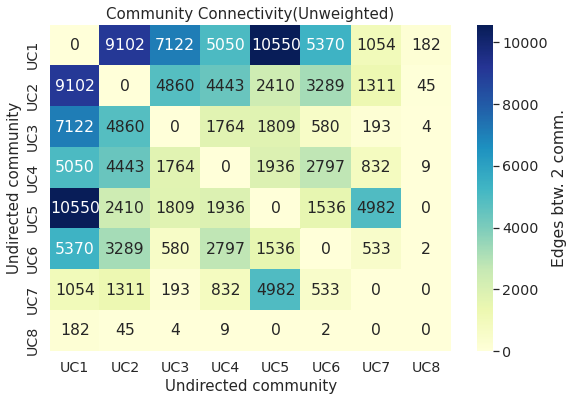

In [109]:
plt.figure(figsize=(9,6))

#sns.heatmap(comm_connectivity_array  , cmap="YlGnBu")
connect_arr = deepcopy(comm_connnectivity_array)
connect_arr = connect_arr-np.diag(np.diag(comm_connnectivity_array))


sns.heatmap(connect_arr, annot=True, cmap="YlGnBu",fmt="d",cbar_kws={'label': 'Edges btw. 2 comm.'},
           vmin=min(comm_connnectivity_array.flatten()), 
           xticklabels=["UC%d"%(i+1) for i in range(ncomm_undir)],
           yticklabels=["UC%d"%(i+1) for i in range(ncomm_undir)]  )
sns.set(font_scale=1.3)

plt.xlabel("Undirected community",size=15)
plt.ylabel("Undirected community",size=15)
plt.title("Community Connectivity(Unweighted)",size=15)
plt.savefig("comm_connect_undirected.pdf", facecolor="white", bbox_inches="tight", dpi=600)

In [110]:
np.savetxt("undirComm_connect_matrix.txt", connect_arr, fmt="%d")

# Selct color maps for visualization

In [77]:
import matplotlib
import matplotlib.pyplot as plt

In [35]:
colors = []
for c in plt.cm.tab20.colors: 
    
    colors.append(matplotlib.colors.to_hex(c))
print(tuple(colors))

('#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f', '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5')


In [37]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from colorspacious import cspace_converter

cmaps = {}

gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))


def plot_color_gradients(category, cmap_list):
    # Create figure and adjust figure height to number of colormaps
    nrows = len(cmap_list)
    figh = 0.35 + 0.15 + (nrows + (nrows - 1) * 0.1) * 0.22
    fig, axs = plt.subplots(nrows=nrows + 1, figsize=(6.4, figh))
    fig.subplots_adjust(top=1 - 0.35 / figh, bottom=0.15 / figh,
                        left=0.2, right=0.99)
    axs[0].set_title(f'{category} colormaps', fontsize=14)

    for ax, name in zip(axs, cmap_list):
        ax.imshow(gradient, aspect='auto', cmap=plt.get_cmap(name))
        ax.text(-0.01, 0.5, name, va='center', ha='right', fontsize=10,
                transform=ax.transAxes)

    # Turn off *all* ticks & spines, not just the ones with colormaps.
    for ax in axs:
        ax.set_axis_off()

    # Save colormap list for later.
    cmaps[category] = cmap_list

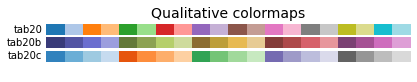

In [38]:
plot_color_gradients('Qualitative',
                     [ 'tab20', 'tab20b',
                      'tab20c'])


# Undirected network overlayed on anatomical regions

In [4]:
import matplotlib

# final arrangement of colors
colors_region=[
(174/255,199/255,232/255), (245/255,126/255,32/255), 
(252/255,186/255,121/255), (45/255,160/255,72/255), 
(246/255,150/255,150/255), (128/255,127/255,127/255),
(146/255,103/255,172/255), (197/255,176/255,213/255),
(140/255,87/255,76/255), (215/255,122/255,177/255),
(50/255,185/255,203/255), (157/255,208/255,137/255)
] 

colors = [matplotlib.colors.to_hex(c) for c in colors_region]
colors

['#aec7e8',
 '#f57e20',
 '#fcba79',
 '#2da048',
 '#f69696',
 '#807f7f',
 '#9267ac',
 '#c5b0d5',
 '#8c574c',
 '#d77ab1',
 '#32b9cb',
 '#9dd089']

In [5]:
neuron_names = pd.read_csv("neuron_names.txt", header=None).iloc[:,0].tolist()
neuron_names

['20150327_1013_BGUG_HuC_ltRFP_d5_F2',
 '20150402_1013_BGUG_HuC_ltRFP_d5_F3',
 '20160512_1013_BGUG_HuC_ltRFP_d6_F6_Neuron2',
 '20160519_1013_BGUG_HuC_ltRFP_d6_F1',
 '20160519_1013_BGUG_HuC_ltRFP_d6_F6',
 '20160526_1013_BGUG_HuC_ltRFP_d6_F2_Neuron1',
 '20160526_1013_BGUG_HuC_ltRFP_d6_F2_Neuron2',
 '20160526_1013_BGUG_HuC_ltRFP_d6_F4',
 '20160601_1013_BGUG_HuC_ltRFP_d6_F1',
 '20160616_1013_BGUG_HuC_ltRFP_d7_F1',
 '20160623_1013_BGUG_HuC_ltRFP_d6_F4',
 '20160720_1013_BGUG_HuC_ltRFP_d6_F3',
 '20160720_1013_BGUG_HuC_ltRFP_d6_F4',
 '20160720_1013_BGUG_HuC_ltRFP_d6_F8_Neuron1',
 '20160726_1013_BGUG_HuC_ltRFP_d6_F1',
 '20160726_1013_BGUG_HuC_ltRFP_d6_F2',
 '20160726_1013_BGUG_HuC_ltRFP_d6_F3',
 '20160906_1013_BGUG_HuC_ltRFP_d5_F1',
 '20160906_1013_BGUG_HuC_ltRFP_d5_F2',
 '20160906_1013_BGUG_HuC_ltRFP_d5_F7',
 '20160907_1013_BGUG_HuC_ltRFP_d6_F2_Neuron2',
 '20160907_1013_BGUG_HuC_ltRFP_d6_F10_Neuron2',
 '20160908_1013_BGUG_HuC_ltRFP_d7_F2',
 '20160908_1013_BGUG_HuC_ltRFP_d7_F5',
 '20160912_1013

In [6]:
# neurons_regions2.npy is a new neuron-region mapping with minimal unassigned neurons ~ 60
neuron_region_arr = np.load("neurons_regions2.npy")
neuron_region_arr

array([['20150327_1013_BGUG_HuC_ltRFP_d5_F2', 'tectum_tori'],
       ['20150402_1013_BGUG_HuC_ltRFP_d5_F3', 'tectum_tori'],
       ['20160512_1013_BGUG_HuC_ltRFP_d6_F6_Neuron2', 'tectum_tori'],
       ...,
       ['T_1600520_8_4', 'medulla_oblongata'],
       ['T_1600520_8_5', 'retina'],
       ['T_1600520_8_6', '']], dtype='<U44')

In [7]:
neuron_region_dict = {neuron_region_arr[i,0]:neuron_region_arr[i,1] for i in range(len(neuron_region_arr))}
neuron_region_dict

{'20150327_1013_BGUG_HuC_ltRFP_d5_F2': 'tectum_tori',
 '20150402_1013_BGUG_HuC_ltRFP_d5_F3': 'tectum_tori',
 '20160512_1013_BGUG_HuC_ltRFP_d6_F6_Neuron2': 'tectum_tori',
 '20160519_1013_BGUG_HuC_ltRFP_d6_F1': 'tectum_tori',
 '20160519_1013_BGUG_HuC_ltRFP_d6_F6': 'tectum_tori',
 '20160526_1013_BGUG_HuC_ltRFP_d6_F2_Neuron1': 'tectum_tori',
 '20160526_1013_BGUG_HuC_ltRFP_d6_F2_Neuron2': 'tectum_tori',
 '20160526_1013_BGUG_HuC_ltRFP_d6_F4': 'tectum_tori',
 '20160601_1013_BGUG_HuC_ltRFP_d6_F1': 'tectum_tori',
 '20160616_1013_BGUG_HuC_ltRFP_d7_F1': 'tectum_tori',
 '20160623_1013_BGUG_HuC_ltRFP_d6_F4': 'tectum_tori',
 '20160720_1013_BGUG_HuC_ltRFP_d6_F3': 'tectum_tori',
 '20160720_1013_BGUG_HuC_ltRFP_d6_F4': 'tectum_tori',
 '20160720_1013_BGUG_HuC_ltRFP_d6_F8_Neuron1': 'tectum_tori',
 '20160726_1013_BGUG_HuC_ltRFP_d6_F1': 'tectum_tori',
 '20160726_1013_BGUG_HuC_ltRFP_d6_F2': 'pretectum',
 '20160726_1013_BGUG_HuC_ltRFP_d6_F3': 'tectum_tori',
 '20160906_1013_BGUG_HuC_ltRFP_d5_F1': 'tectum_tori'

In [8]:
#count=0
for i, j in zip(neuron_region_dict.keys(), neuron_names):
    #print(count)
    if i!=j:
        print(i,j)
        print("Not same")
        break
    #count+=1    

In [9]:
node_region_dict = {}
i=0
for key, value in neuron_region_dict.items():
    node_region_dict[i]=value
    i+=1

In [10]:
node_region_dict

{0: 'tectum_tori',
 1: 'tectum_tori',
 2: 'tectum_tori',
 3: 'tectum_tori',
 4: 'tectum_tori',
 5: 'tectum_tori',
 6: 'tectum_tori',
 7: 'tectum_tori',
 8: 'tectum_tori',
 9: 'tectum_tori',
 10: 'tectum_tori',
 11: 'tectum_tori',
 12: 'tectum_tori',
 13: 'tectum_tori',
 14: 'tectum_tori',
 15: 'pretectum',
 16: 'tectum_tori',
 17: 'tectum_tori',
 18: 'tectum_tori',
 19: 'tectum_tori',
 20: 'tectum_tori',
 21: 'tectum_tori',
 22: 'pretectum',
 23: 'tectum_tori',
 24: 'tectum_tori',
 25: 'tectum_tori',
 26: 'tectum_tori',
 27: 'tectum_tori',
 28: 'tectum_tori',
 29: 'tectum_tori',
 30: 'pretectum',
 31: 'tectum_tori',
 32: 'tectum_tori',
 33: 'tectum_tori',
 34: 'tectum_tori',
 35: 'pretectum',
 36: 'pretectum',
 37: 'tectum_tori',
 38: 'tectum_tori',
 39: 'tectum_tori',
 40: 'tectum_tori',
 41: 'tectum_tori',
 42: 'tectum_tori',
 43: 'pretectum',
 44: 'tectum_tori',
 45: 'tectum_tori',
 46: 'pretectum',
 47: 'tectum_tori',
 48: 'tectum_tori',
 49: 'tectum_tori',
 50: 'tectum_tori',
 51:

In [11]:
(np.unique(list(node_region_dict.values())))

array(['', 'cerebellum', 'dorsal_thalamus', 'eminentia_talami',
       'hypothalamus', 'medulla_oblongata', 'peripheral_nervous_system ',
       'pretectum', 'retina', 'tectum_tori', 'tegmentum', 'telencephalon',
       'ventral_thalamus'], dtype='<U26')

In [12]:
# invert the dictionary, with key name as region name and values as list of neurons belonging to the region.
inv_map = {}
for k, v in node_region_dict.items():
    inv_map[v] = inv_map.get(v, []) + [k]

sortedDict = {}

#for region_name in region_list:
#    sortedDict[region_name] = inv_map[region_name]

sortedDict = dict( sorted(inv_map.items(), key=lambda x: x[0].lower()) )        
sortedDict["w_Unassigned"]  = sortedDict.pop("")   
    
#

In [13]:
np.array(list(sortedDict.keys()))

array(['cerebellum', 'dorsal_thalamus', 'eminentia_talami',
       'hypothalamus', 'medulla_oblongata', 'peripheral_nervous_system ',
       'pretectum', 'retina', 'tectum_tori', 'tegmentum', 'telencephalon',
       'ventral_thalamus', 'w_Unassigned'], dtype='<U26')

In [14]:
region_list = list(sortedDict.keys())

In [15]:
np.array(region_list)

array(['cerebellum', 'dorsal_thalamus', 'eminentia_talami',
       'hypothalamus', 'medulla_oblongata', 'peripheral_nervous_system ',
       'pretectum', 'retina', 'tectum_tori', 'tegmentum', 'telencephalon',
       'ventral_thalamus', 'w_Unassigned'], dtype='<U26')

In [16]:
A_undir = np.load("undirected_adj_synaptic_cleft_5.000 um.npy")
A_undir_copy = deepcopy(A_undir)!=0

In [17]:
node_sort = []
for values in sortedDict.values():

    node_sort+=list(values)

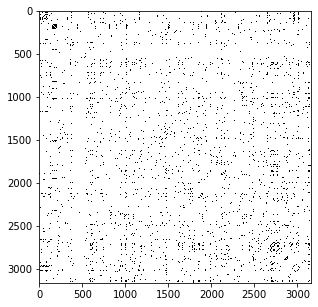

In [18]:
fig = plt.figure(figsize=(5, 5)) # in inches
plt.imshow(A_undir_copy, cmap="Greys", interpolation="none")
    

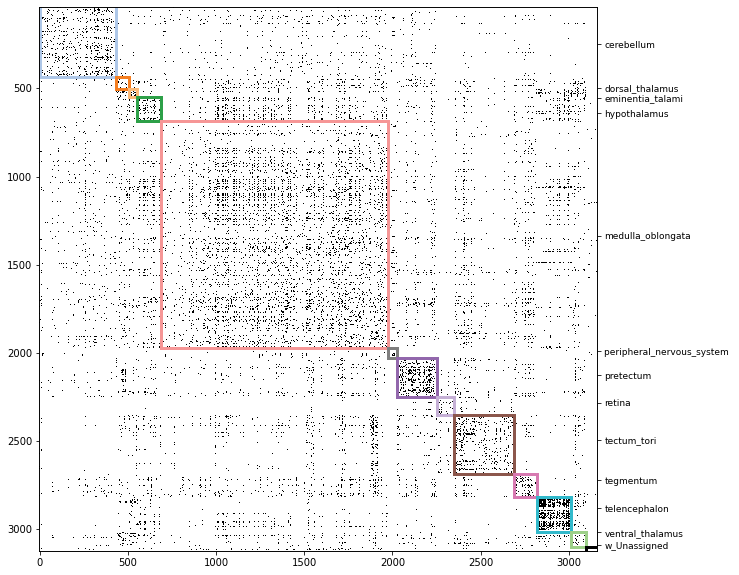

In [19]:
from matplotlib import patches

from matplotlib.ticker import FormatStrFormatter

#fig, ax1 = plt.subplots(figsize=(5,5))#
plt.figure(figsize=(10, 10)) # in inches



plt.imshow(A_undir_copy[node_sort][:,node_sort], cmap="Greys", interpolation="none")


# The rest is just if you have sorted nodes by a partition and want to
# highlight the module boundaries

partitions = [list(value) for value in sortedDict.values() ]
#print(partitions)

#colors = ('#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a',
# '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#e377c2', 
# '#f7b6d2', '#7f7f7f', '#c7c7c7', '#bcbd22', '#17becf', "black")
colors = ['#aec7e8',
 '#f57e20',
 '#fcba79',
 '#2da048',
 '#f69696',
 '#807f7f',
 '#9267ac',
 '#c5b0d5',
 '#8c574c',
 '#d77ab1',
 '#32b9cb',
 '#9dd089',"black"]

colors = colors[:len(partitions)]
assert len(partitions) == len(colors)
#if len(partitions)!=len(colors):
#    print("Error")

ax = plt.gca()

ticks_regions = []
current_idx = 0
idx_list = []

#count=0
for partition, color in zip(partitions, colors):
    
    ax.add_patch(patches.Rectangle((current_idx, current_idx),
                                  len(partition), # Width
                                  len(partition), # Height
                                  facecolor="none",
                                  edgecolor=color,
                                  linewidth="3"))
    ticks_regions.append( current_idx + len(partition)/2 )
    
    current_idx += len(partition)
    #idx_list.append(current_idx)
    #count+=len(partition)

ax2 = ax.twinx()
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# correct_ticks = 3163-np.array(idx_list)+np.array([len(partition) for partition in partitions])/2
ax2.set_yticks(3163-np.array(ticks_regions) )
#ax2.set_yticks(np.linspace(0,3162,20) )

ax2.set_ylim(0,3162)

ax2.set_yticklabels(list(sortedDict.keys()), fontsize=9)

plt.savefig("./Undirected_anatomical_connectivity/anatomical_regions_matrixRepresentation_undirected.pdf",
            facecolor="white", bbox_inches="tight", dpi=600)

plt.show()

In [20]:
sortedDict

{'cerebellum': [209,
  213,
  239,
  242,
  249,
  250,
  251,
  262,
  271,
  280,
  285,
  286,
  290,
  293,
  295,
  296,
  303,
  315,
  318,
  328,
  340,
  352,
  353,
  382,
  383,
  384,
  422,
  448,
  462,
  464,
  466,
  470,
  471,
  475,
  477,
  479,
  481,
  483,
  484,
  489,
  494,
  498,
  499,
  523,
  529,
  534,
  540,
  548,
  550,
  562,
  564,
  567,
  585,
  591,
  600,
  601,
  604,
  607,
  611,
  615,
  619,
  631,
  637,
  638,
  639,
  654,
  673,
  675,
  680,
  681,
  691,
  695,
  702,
  704,
  707,
  713,
  731,
  732,
  733,
  735,
  737,
  743,
  757,
  759,
  761,
  765,
  766,
  771,
  775,
  777,
  778,
  781,
  785,
  786,
  790,
  791,
  794,
  802,
  807,
  808,
  811,
  828,
  831,
  834,
  843,
  851,
  857,
  858,
  861,
  881,
  906,
  909,
  910,
  922,
  923,
  931,
  932,
  939,
  950,
  951,
  979,
  984,
  996,
  1006,
  1007,
  1018,
  1019,
  1020,
  1033,
  1034,
  1035,
  1036,
  1040,
  1043,
  1045,
  1050,
  1064,
  1074,
  107

In [70]:
A_undirected = np.load("undirected_adj_synaptic_cleft_5.000 um.npy")
G_undir_nx = get_graph_undirected(A_undirected, "neuron_names.txt")


In [71]:
comm_connnectivity_array = []

for region1 in sortedDict.keys():
    
    nodes_Cmt1 = sortedDict[region1]
    
    for region2 in sortedDict.keys():
        
        nodes_Cmt2 = sortedDict[region2]
        
        count=0
        for i in nodes_Cmt1:
            for j in nodes_Cmt2:
                if G_undir_nx.has_edge(i, j):
                    count+=1
        comm_connnectivity_array.append(count)            
        

comm_connnectivity_array = np.array(comm_connnectivity_array).reshape((len(sortedDict.keys()), 
                                                                       len(sortedDict.keys())))        
    



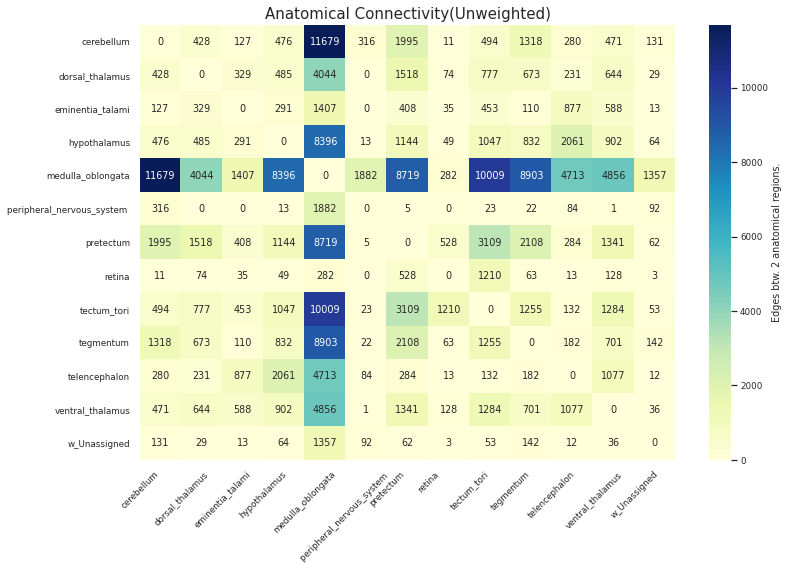

In [76]:
plt.figure(figsize=(12,8))

#sns.heatmap(comm_connectivity_array  , cmap="YlGnBu")
connect_arr = deepcopy(comm_connnectivity_array)
connect_arr = connect_arr-np.diag(np.diag(comm_connnectivity_array))


sns.heatmap(connect_arr, annot=True, cmap="YlGnBu",fmt="d",cbar_kws={'label': 'Edges btw. 2 anatomical regions.'},
           vmin=min(comm_connnectivity_array.flatten()))
sns.set(font_scale=0.8)

#plt.xlabel("Undirected community",size=15)
#plt.ylabel("Undirected community",size=15)
plt.xticks(np.arange(connect_arr.shape[0]), list(sortedDict.keys()),rotation=45)
plt.yticks(np.arange(connect_arr.shape[0])+0.5, list(sortedDict.keys()), rotation=0)


plt.title("Anatomical Connectivity(Unweighted)",size=15)
plt.savefig("anatomical_connectivity.pdf", facecolor="white", bbox_inches="tight", dpi=600)

In [77]:
connect_arr.shape

(13, 13)

In [78]:
np.savetxt("anatomical_connectivity_matrix.txt", connect_arr[:12,:12], fmt="%d")

In [26]:
np.loadtxt("./Undirected_anatomical_connectivity/anatomical_connectivity_matrix_undirected.txt", dtype=int)

array([[    0,   428,   127,   476, 11679,   316,  1995,    11,   494,
         1318,   280,   471],
       [  428,     0,   329,   485,  4044,     0,  1518,    74,   777,
          673,   231,   644],
       [  127,   329,     0,   291,  1407,     0,   408,    35,   453,
          110,   877,   588],
       [  476,   485,   291,     0,  8396,    13,  1144,    49,  1047,
          832,  2061,   902],
       [11679,  4044,  1407,  8396,     0,  1882,  8719,   282, 10009,
         8903,  4713,  4856],
       [  316,     0,     0,    13,  1882,     0,     5,     0,    23,
           22,    84,     1],
       [ 1995,  1518,   408,  1144,  8719,     5,     0,   528,  3109,
         2108,   284,  1341],
       [   11,    74,    35,    49,   282,     0,   528,     0,  1210,
           63,    13,   128],
       [  494,   777,   453,  1047, 10009,    23,  3109,  1210,     0,
         1255,   132,  1284],
       [ 1318,   673,   110,   832,  8903,    22,  2108,    63,  1255,
            0,   182

In [79]:
list(sortedDict.keys())

['cerebellum',
 'dorsal_thalamus',
 'eminentia_talami',
 'hypothalamus',
 'medulla_oblongata',
 'peripheral_nervous_system ',
 'pretectum',
 'retina',
 'tectum_tori',
 'tegmentum',
 'telencephalon',
 'ventral_thalamus',
 'w_Unassigned']

# Directed network overlayed on anatomical regions

In [22]:
neuron_names = pd.read_csv("neuron_names.txt", header=None).iloc[:,0].tolist()
neuron_region_arr = np.load("neurons_regions2.npy")
neuron_region_dict = {neuron_region_arr[i,0]:neuron_region_arr[i,1] for i in range(len(neuron_region_arr))}


# check: if neuron names list and neurons_regions2.npy have the same ordering or not. 

#count=0
for i, j in zip(neuron_region_dict.keys(), neuron_names):
    #print(count)
    if i!=j:
        print(i,j)
        print("Not same")
        break
    #count+=1    
    


# node number and anatomical region name    
node_region_dict = {}
i=0
for key, value in neuron_region_dict.items():
    node_region_dict[i]=value
    i+=1
    
# invert the dictionary, with key name as region name and values as list of neurons belonging to the region.
inv_map = {}
for k, v in node_region_dict.items():
    inv_map[v] = inv_map.get(v, []) + [k]

sortedDict = {}

#for region_name in region_list:
#    sortedDict[region_name] = inv_map[region_name]

sortedDict = dict( sorted(inv_map.items(), key=lambda x: x[0].lower()) )        
sortedDict["w_Unassigned"]  = sortedDict.pop("")   
    
# flatten the list which is arranged according to anatomical regions
node_sort = []
for values in sortedDict.values():
    node_sort+=list(values)

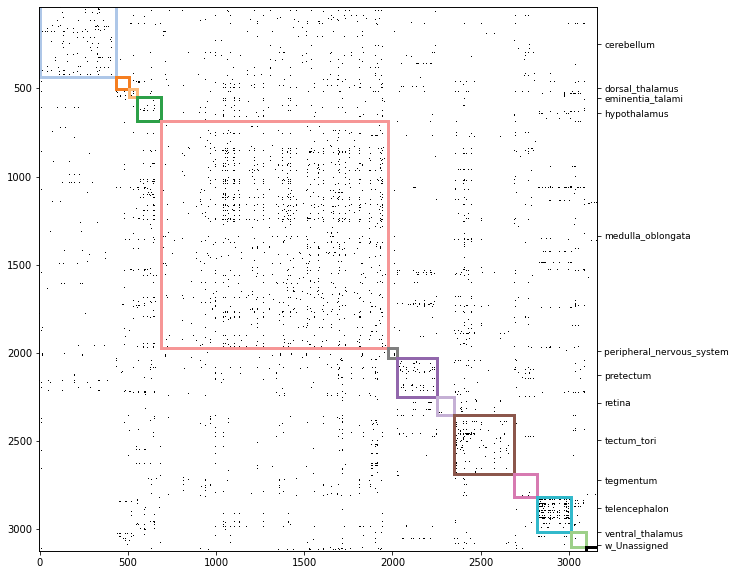

In [23]:
from matplotlib import patches

from matplotlib.ticker import FormatStrFormatter


A_directed = np.load("adjacency_synaptic_cleft_5.000um.npy")
A_dir_copy = deepcopy(A_directed)!=0


plt.figure(figsize=(10, 10)) # in inches

plt.imshow(A_dir_copy[node_sort][:,node_sort], cmap="Greys", interpolation="none")


# The rest is just if you have sorted nodes by a partition and want to
# highlight the module boundaries

partitions = [list(value) for value in sortedDict.values() ]
#print(partitions)

#colors = ('#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a',
# '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#e377c2', 
# '#f7b6d2', '#7f7f7f', '#c7c7c7', '#bcbd22', '#17becf', "black")
colors = ['#aec7e8',
 '#f57e20',
 '#fcba79',
 '#2da048',
 '#f69696',
 '#807f7f',
 '#9267ac',
 '#c5b0d5',
 '#8c574c',
 '#d77ab1',
 '#32b9cb',
 '#9dd089',"black"]



colors = colors[:len(partitions)]
assert len(partitions) == len(colors)
#if len(partitions)!=len(colors):
#    print("Error")

ax = plt.gca()

ticks_regions = []
current_idx = 0
idx_list = []

#count=0
for partition, color in zip(partitions, colors):
    
    ax.add_patch(patches.Rectangle((current_idx, current_idx),
                                  len(partition), # Width
                                  len(partition), # Height
                                  facecolor="none",
                                  edgecolor=color,
                                  linewidth="3"))
    ticks_regions.append( current_idx + len(partition)/2 )
    
    current_idx += len(partition)
    #idx_list.append(current_idx)
    #count+=len(partition)

ax2 = ax.twinx()
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# correct_ticks = 3163-np.array(idx_list)+np.array([len(partition) for partition in partitions])/2
ax2.set_yticks(3163-np.array(ticks_regions) )
#ax2.set_yticks(np.linspace(0,3162,20) )

ax2.set_ylim(0,3162)

ax2.set_yticklabels(list(sortedDict.keys()), fontsize=9)

plt.savefig("./Directed_anatomical_connectivity/anatomical_regions_matrixRepresentation_directed.pdf",
            facecolor="white", bbox_inches="tight", dpi=600)

plt.show()

In [5]:
fname = "adjacency_synaptic_cleft_5.000um.npy"

#fname = "./neurites_axonTermials/adjacency_axon25July.txt"#+str(10)+".txt"

G_dir_nx = get_graph_directed(fname, "neuron_names.txt")



In [6]:
comm_connnectivity_array = []

for region1 in sortedDict.keys():
    
    nodes_Cmt1 = sortedDict[region1]
    
    for region2 in sortedDict.keys():
        
        nodes_Cmt2 = sortedDict[region2]
        
        count=0
        for i in nodes_Cmt1:
            for j in nodes_Cmt2:
                if G_dir_nx.has_edge(i, j):
                    count+=1
        comm_connnectivity_array.append(count)            
        

comm_connnectivity_array = np.array(comm_connnectivity_array).reshape((len(sortedDict.keys()), 
                                                                       len(sortedDict.keys())))        


In [7]:
fpath_save = "./Directed_anatomical_connectivity/"

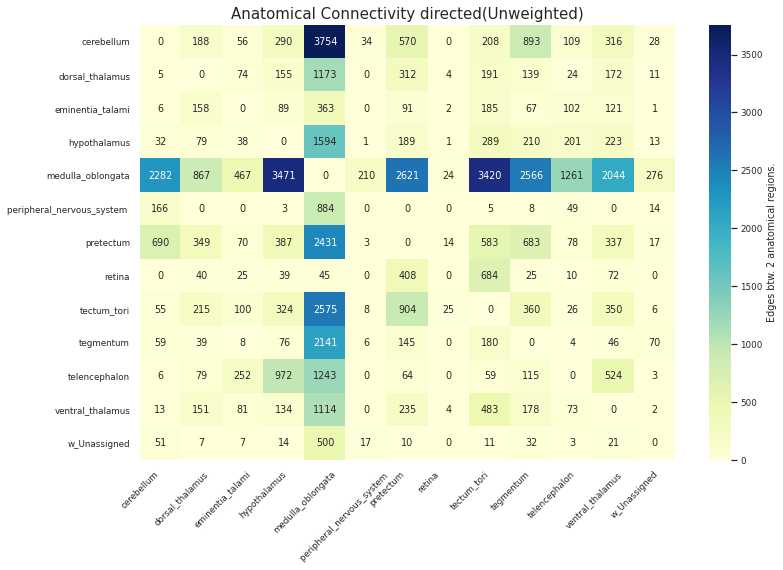

In [10]:
plt.figure(figsize=(12,8))

#sns.heatmap(comm_connectivity_array  , cmap="YlGnBu")
connect_arr = deepcopy(comm_connnectivity_array)
connect_arr = connect_arr-np.diag(np.diag(comm_connnectivity_array))


sns.heatmap(connect_arr, annot=True, cmap="YlGnBu",fmt="d",cbar_kws={'label': 'Edges btw. 2 anatomical regions.'},
           vmin=min(comm_connnectivity_array.flatten()))
sns.set(font_scale=0.8)

#plt.xlabel("Undirected community",size=15)
#plt.ylabel("Undirected community",size=15)
plt.xticks(np.arange(connect_arr.shape[0]), list(sortedDict.keys()),rotation=45)
plt.yticks(np.arange(connect_arr.shape[0])+0.5, list(sortedDict.keys()), rotation=0)


plt.title("Anatomical Connectivity directed(Unweighted)",size=15)

plt.savefig(fpath_save+"anatomical_connectivity_directed.pdf", 
            facecolor="white", bbox_inches="tight", dpi=600)

In [11]:
len(connect_arr)

13

In [12]:
# neglect last category w_unassigned
np.savetxt(fpath_save+"anatomical_connectivity_matrix_directed.txt", connect_arr[:12,:12], fmt="%d")

In [27]:
np.loadtxt("./Directed_anatomical_connectivity/anatomical_connectivity_matrix_directed.txt", dtype=int)

array([[   0,  188,   56,  290, 3754,   34,  570,    0,  208,  893,  109,
         316],
       [   5,    0,   74,  155, 1173,    0,  312,    4,  191,  139,   24,
         172],
       [   6,  158,    0,   89,  363,    0,   91,    2,  185,   67,  102,
         121],
       [  32,   79,   38,    0, 1594,    1,  189,    1,  289,  210,  201,
         223],
       [2282,  867,  467, 3471,    0,  210, 2621,   24, 3420, 2566, 1261,
        2044],
       [ 166,    0,    0,    3,  884,    0,    0,    0,    5,    8,   49,
           0],
       [ 690,  349,   70,  387, 2431,    3,    0,   14,  583,  683,   78,
         337],
       [   0,   40,   25,   39,   45,    0,  408,    0,  684,   25,   10,
          72],
       [  55,  215,  100,  324, 2575,    8,  904,   25,    0,  360,   26,
         350],
       [  59,   39,    8,   76, 2141,    6,  145,    0,  180,    0,    4,
          46],
       [   6,   79,  252,  972, 1243,    0,   64,    0,   59,  115,    0,
         524],
       [  13,  151,  

# Anatomical regions - Undirected communities matrix

In [15]:
neuron_names[:5]

['20150327_1013_BGUG_HuC_ltRFP_d5_F2',
 '20150402_1013_BGUG_HuC_ltRFP_d5_F3',
 '20160512_1013_BGUG_HuC_ltRFP_d6_F6_Neuron2',
 '20160519_1013_BGUG_HuC_ltRFP_d6_F1',
 '20160519_1013_BGUG_HuC_ltRFP_d6_F6']

In [71]:
df_undir_comm = pd.read_csv("averaged_undir_leiden.csv")
df_undir_comm

,Node,Community,Name
0,0,5.0,20150327_1013_BGUG_HuC_ltRFP_d5_F2
1,1,3.0,20150402_1013_BGUG_HuC_ltRFP_d5_F3
2,2,3.0,20160512_1013_BGUG_HuC_ltRFP_d6_F6_Neuron2
3,3,5.0,20160519_1013_BGUG_HuC_ltRFP_d6_F1
4,4,3.0,20160519_1013_BGUG_HuC_ltRFP_d6_F6
...,...,...,...
3126,3158,0.0,T_1600520_8_2
3127,3159,6.0,T_1600520_8_3
3128,3160,3.0,T_1600520_8_4
3129,3161,3.0,T_1600520_8_5


In [72]:
UC_node_dict = {}
# UC only 7+1 communities
for i in np.sort(df_undir_comm.Community.unique())[:8].astype(int):
    
    UC_node_dict["UC"+str(i+1)] = df_undir_comm[df_undir_comm.Community == i].Node.tolist()


In [73]:
for key, value in UC_node_dict.items():
    print(key, len(value))

UC1 702
UC2 591
UC3 556
UC4 371
UC5 326
UC6 283
UC7 250
UC8 38


In [74]:
anatomRegion_comm_matrix = []

# we don't consider w_unassigned
anaRegion_names = list(sortedDict.keys())[:-1]

for anatomRegion_name in anaRegion_names:
    anatomRegion_nodes = sortedDict[anatomRegion_name]
    
    for comm_name in UC_node_dict.keys():
        
        UC_nodes = UC_node_dict[comm_name]
        
        common_nodes = set(anatomRegion_nodes).intersection( set( UC_nodes  ) )
        
        anatomRegion_comm_matrix.append(len(common_nodes))
        
anatomRegion_comm_matrix = np.array(anatomRegion_comm_matrix).reshape(len(anaRegion_names), 
                                                                      len(UC_node_dict.keys()))
    
    
    
    
    

In [75]:
anatomRegion_comm_matrix

array([[ 35,  35, 354,   4,   3,   3,   1,   0],
       [ 17,   8,   7,  16,  16,   3,   3,   0],
       [  3,   1,   0,   6,   3,   3,  27,   0],
       [ 34,   5,   0,  15,  59,   8,  10,   5],
       [357, 474, 130,  31, 217,  47,   1,  28],
       [  9,  32,   1,   0,   0,   0,  12,   1],
       [109,   3,  12,  86,   1,  10,   1,   0],
       [  0,   0,   0,  26,   0,  42,   1,   0],
       [ 16,  11,   2, 161,   1, 145,   0,   0],
       [ 72,   2,  46,   4,   2,   4,   1,   0],
       [  0,   1,   1,   0,  15,   0, 178,   0],
       [ 17,   6,   3,  22,   9,  15,  15,   0]])

In [77]:
np.savetxt("./Undirected_anatomical_connectivity/anatomRegions_UC_matrix.txt",anatomRegion_comm_matrix, fmt="%d")

In [42]:
list(sortedDict.keys())[:-1]

['cerebellum',
 'dorsal_thalamus',
 'eminentia_talami',
 'hypothalamus',
 'medulla_oblongata',
 'peripheral_nervous_system ',
 'pretectum',
 'retina',
 'tectum_tori',
 'tegmentum',
 'telencephalon',
 'ventral_thalamus']

# Anatomical regions - Directed communities matrix

In [78]:
df_dir_comm = pd.read_csv("averaged_dir_leiden.csv")
df_dir_comm

,Node,Community,Name
0,0,1.0,20150327_1013_BGUG_HuC_ltRFP_d5_F2
1,1,1.0,20150402_1013_BGUG_HuC_ltRFP_d5_F3
2,2,1.0,20160512_1013_BGUG_HuC_ltRFP_d6_F6_Neuron2
3,3,1.0,20160519_1013_BGUG_HuC_ltRFP_d6_F1
4,4,1.0,20160519_1013_BGUG_HuC_ltRFP_d6_F6
...,...,...,...
3111,3158,0.0,T_1600520_8_2
3112,3159,5.0,T_1600520_8_3
3113,3160,1.0,T_1600520_8_4
3114,3161,1.0,T_1600520_8_5


In [79]:
DC_node_dict = {}
# DC only 7 communities
for i in np.sort(df_dir_comm.Community.unique())[:7].astype(int):
    
    DC_node_dict["DC"+str(i+1)] = df_dir_comm[df_dir_comm.Community == i].Node.tolist()


In [80]:
for key, value in DC_node_dict.items():
    print(key, len(value))

DC1 931
DC2 630
DC3 624
DC4 327
DC5 339
DC6 234
DC7 27


In [81]:
anatomRegion_comm_matrix2 = []

# we don't consider w_unassigned
for anatomRegion_name in list(sortedDict.keys())[:-1]:
    anatomRegion_nodes = sortedDict[anatomRegion_name]
    
    for comm_name in DC_node_dict.keys():
        
        DC_nodes = DC_node_dict[comm_name]
        
        common_nodes = set(anatomRegion_nodes).intersection( set( DC_nodes  ) )
        
        anatomRegion_comm_matrix2.append(len(common_nodes))
        
anatomRegion_comm_matrix2 = np.array(anatomRegion_comm_matrix2).reshape(len(list(sortedDict.keys())[:-1]), len(DC_node_dict.keys()))


In [82]:
anatomRegion_comm_matrix2

array([[107,   8,  55,   3, 261,   1,   0],
       [ 24,  17,   9,  14,   0,   6,   0],
       [  4,  11,   2,   7,   0,  21,   0],
       [ 38,  21,   8,  58,   0,  10,   1],
       [463,  80, 468, 203,  45,   1,  23],
       [  9,   0,  34,   0,   0,  11,   0],
       [100,  91,   5,   0,  25,   1,   0],
       [  0,  64,   0,   1,   2,   0,   0],
       [ 22, 295,  14,   2,   1,   0,   0],
       [111,  10,   2,   2,   5,   1,   0],
       [  2,   0,   2,  24,   0, 167,   0],
       [ 17,  32,  11,  13,   0,  14,   0]])

In [85]:
np.savetxt("./Directed_anatomical_connectivity/anatomRegions_DC_matrix.txt",anatomRegion_comm_matrix2, fmt="%d")
